# Проект для компании "ТелеДом"

## Описание проекта: телекоммуникации

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.

**Описание услуг**

Оператор предоставляет два основных типа услуг: 

- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.

- Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:

- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);

- Выделенная линия технической поддержки (TechSupport);

- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);

- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

**Описание данных**

Данные состоят из нескольких файлов, полученных из разных источников:

1) contract_new.csv — информация о договоре;

2) personal_new.csv — персональные данные клиента;

3) internet_new.csv — информация об интернет-услугах;

4) phone_new.csv — информация об услугах телефонии.

----
***Файл contract_new.csv***
- customerID — идентификатор абонента;

- BeginDate — дата начала действия договора;

- EndDate — дата окончания действия договора;

- Type — тип оплаты: раз в год-два или ежемесячно;

- PaperlessBilling — электронный расчётный лист;

- PaymentMethod — тип платежа;

- MonthlyCharges — расходы за месяц;

- TotalCharges — общие расходы абонента.
----
***Файл personal_new.csv***

- customerID — идентификатор пользователя;

- gender — пол;

- SeniorCitizen — является ли абонент пенсионером;

- Partner — есть ли у абонента супруг или супруга;

- Dependents — есть ли у абонента дети.
----
***Файл internet_new.csv***

- customerID — идентификатор пользователя;

- InternetService — тип подключения;

- OnlineSecurity — блокировка опасных сайтов;

- OnlineBackup — облачное хранилище файлов для резервного копирования данных;

- DeviceProtection — антивирус;

- TechSupport — выделенная линия технической поддержки;

- StreamingTV — стриминговое телевидение;

- StreamingMovies — каталог фильмов.
----
***Файл phone_new.csv***

- customerID — идентификатор пользователя;

- MultipleLines — подключение телефона к нескольким линиям одновременно.
----
Во всех файлах столбец customerID содержит код клиента. Информация о договорах актуальна на 1 февраля 2020 года.

## Загрузка данных 

In [1]:
!pip install scikit-learn==1.6.1 -q

In [2]:
!pip install --upgrade scikit-learn

In [3]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [4]:
from lightgbm import LGBMClassifier as lgb

In [5]:
!pip install shap

     |████████████████████████████████| 539 kB 2.1 MB/s eta 0:00:01


In [6]:
!pip install phik -q

In [7]:
# загрузка необходимых библиотек
import pandas as pd 
import numpy as np
from scipy import stats as st
import seaborn as sns

import math
import matplotlib.pyplot as plt
import phik
import shap

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler,MinMaxScaler, OrdinalEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor

In [8]:
contract_new = pd.read_csv('/datasets/contract_new.csv')
contract_new.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [9]:
personal_new = pd.read_csv('/datasets/personal_new.csv')
personal_new.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [10]:
internet_new = pd.read_csv('/datasets/internet_new.csv')
internet_new.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [11]:
phone_new = pd.read_csv('/datasets/phone_new.csv')
phone_new.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Данные загрузили и провели первичный осмотр.

Можем переходить к предобработке данных.

## Предобработка данных

### Файл contract_new

In [12]:
contract_new.info() # общая информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


1) Приведем все названия столбцов к змеиному регистру

In [13]:
contract_new = contract_new.rename(columns={'customerID':'customer_id', 'BeginDate':'begin_date',
                                           'EndDate':'end_date', 'Type':'type',
                                           'PaperlessBilling':'paperless_billing', 'PaymentMethod':'payment_method',
                                           'MonthlyCharges':'monthly_charges', 'TotalCharges':'total_charges'})
print(contract_new.columns)

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')


2) Проверим на явные и неявные дубликаты

In [14]:
for column in contract_new.columns:
    print(f'Список уникальных значений для {column}: {contract_new[column].unique()}')
    print(f'Количество уникальных значений для {column}: {len(contract_new[column].unique())}', '\n')

Список уникальных значений для customer_id: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Количество уникальных значений для customer_id: 7043 

Список уникальных значений для begin_date: ['2020-01-01' '2017-04-01' '2019-10-01' '2016-05-01' '2019-09-01'
 '2019-03-01' '2018-04-01' '2019-04-01' '2017-07-01' '2014-12-01'
 '2019-01-01' '2018-10-01' '2015-04-01' '2015-09-01' '2018-01-01'
 '2014-05-01' '2015-10-01' '2014-03-01' '2018-05-01' '2019-11-01'
 '2019-02-01' '2016-01-01' '2017-08-01' '2015-12-01' '2014-02-01'
 '2018-06-01' '2019-12-01' '2017-11-01' '2019-06-01' '2016-04-01'
 '2017-02-01' '2018-12-01' '2014-04-01' '2018-09-01' '2014-11-01'
 '2016-07-01' '2015-02-01' '2018-07-01' '2014-08-01' '2016-03-01'
 '2018-08-01' '2014-10-01' '2015-06-01' '2016-08-01' '2019-05-01'
 '2017-03-01' '2016-02-01' '2017-09-01' '2014-09-01' '2017-12-01'
 '2016-12-01' '2017-06-01' '2015-05-01' '2016-10-01' '2016-09-01'
 '2019-08-01' '2019-07-01' '2017-05-01' '2017-1

Можем заметить:

- Количество уникальных идентификаторов совпадает с размером датафрейма (7043)

- В столбце ***end_date*** присутствуют не только даты, но и слово No - дата контракта не закончена на момент 1 февраля 2020 года

- Неявных дубликатов нет, однако выявили, что не все данные имеют подходящий тип

----
Также стоит отметить, что для нас не столько важна именно дата окончания договора, сколько важен факт его окончания и его длительность, поэтому для нашего анализа добавим два новых признака:

- ***activity*** - активность пользователя: 1 - договор на момент выгрузки данных действителен, 0 - договор рассторгнут

- ***duration*** - длительность договора: для строчек ***end_date***, в которых указано "No", запишем дату выгрузки данных 2020-02-01

После этого столбцы ***begin_date*** и ***end_date*** мы можем удалить, так как сами по себе даты для нашего анализа не понадобятся

3) Изменение типов данных и добавление новых признаков

In [15]:
contract_new['begin_date'] = pd.to_datetime(contract_new['begin_date'])

contract_new['activity'] = [1 if contract_new['end_date'][i] == 'No' else 0 for i in range(len(contract_new['end_date']))]

contract_new['end_date'] = ['2020-02-01' if contract_new['end_date'][i] == 'No' else contract_new['end_date'][i] for i in range(len(contract_new['end_date']))]
contract_new['end_date'] = pd.to_datetime(contract_new['end_date'])
contract_new['duration'] = (contract_new['end_date'] - contract_new['begin_date']).dt.components.days

contract_new = contract_new.drop(['begin_date', 'end_date'], axis=1)
contract_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   type               7043 non-null   object 
 2   paperless_billing  7043 non-null   object 
 3   payment_method     7043 non-null   object 
 4   monthly_charges    7043 non-null   float64
 5   total_charges      7043 non-null   object 
 6   activity           7043 non-null   int64  
 7   duration           7043 non-null   int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 440.3+ KB


Осталось изменить тип данных в столбце ***total_charges***, для начала просмотрев находятся ли в этом столбце только числа или есть некорректные данные

In [16]:
listik = []
for i in range(0, len(contract_new['total_charges'])):
    try:
        num = float(contract_new['total_charges'][i])
    except:
        listik.append(contract_new['total_charges'][i])
print(listik)

[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']


In [17]:
print(contract_new.iloc[0])

customer_id                7590-VHVEG
type                   Month-to-month
paperless_billing                 Yes
payment_method       Electronic check
monthly_charges                 29.85
total_charges                   31.04
activity                            1
duration                           31
Name: 0, dtype: object


In [18]:
for string in range(0, len(contract_new)):
    if contract_new['total_charges'][string] == ' ':
        print(contract_new.iloc[string], '\n')

customer_id                         4472-LVYGI
type                                  Two year
paperless_billing                          Yes
payment_method       Bank transfer (automatic)
monthly_charges                          52.55
total_charges                                 
activity                                     1
duration                                     0
Name: 488, dtype: object 

customer_id            3115-CZMZD
type                     Two year
paperless_billing              No
payment_method       Mailed check
monthly_charges             20.25
total_charges                    
activity                        1
duration                        0
Name: 753, dtype: object 

customer_id            5709-LVOEQ
type                     Two year
paperless_billing              No
payment_method       Mailed check
monthly_charges             80.85
total_charges                    
activity                        1
duration                        0
Name: 936, dtype: object 


Видим, что в этом столбце присутствуют не только числа, но и пробелы, которые могут говорить о том, что оплаты за услуги не производились. 

Посмотрев все данные о таких пользователях, можно заметить, что у них у всех ***duration*** (длительность действия договора) - 0 дней, то есть они подключили услуги оператора в день выгрузки данных. Их тип оплаты - раз в два года, при этом какой-то начальный месячный платеж был внесен.

Таким образом, изменим пробелы на 0 и изменим тип данных этого столбца.

In [19]:
contract_new.loc[contract_new['total_charges'] == ' ', 'total_charges'] = 0
contract_new['total_charges'] = contract_new['total_charges'].astype('float64')
contract_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   type               7043 non-null   object 
 2   paperless_billing  7043 non-null   object 
 3   payment_method     7043 non-null   object 
 4   monthly_charges    7043 non-null   float64
 5   total_charges      7043 non-null   float64
 6   activity           7043 non-null   int64  
 7   duration           7043 non-null   int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 440.3+ KB


----
Провели предобработку данных из первого датафрейма, можем переходить к следующему

### Файл personal_new

In [20]:
personal_new.info()
personal_new.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


1) Переведем названия столбцов к змеиному регистру

In [21]:
personal_new = personal_new.rename(columns={'customerID':'customer_id', 'SeniorCitizen':'senior_citizen',
                                           'Partner':'partner', 'Dependents':'dependents'})
print(personal_new.columns)

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')


2) Проверка на явные и неявные дубликаты

In [22]:
for column in personal_new.columns:
    print(f'Список уникальных значений для {column}: {personal_new[column].unique()}')
    print(f'Количество уникальных значений для {column}: {len(personal_new[column].unique())}', '\n')

Список уникальных значений для customer_id: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Количество уникальных значений для customer_id: 7043 

Список уникальных значений для gender: ['Female' 'Male']
Количество уникальных значений для gender: 2 

Список уникальных значений для senior_citizen: [0 1]
Количество уникальных значений для senior_citizen: 2 

Список уникальных значений для partner: ['Yes' 'No']
Количество уникальных значений для partner: 2 

Список уникальных значений для dependents: ['No' 'Yes']
Количество уникальных значений для dependents: 2 



В данных не было замечено ни явных, ни неявных дублей.

----
Типы данных для этого датафрейма менять не стоит, они все отмечено верно.

Таким образом можем перейти к предобработке следующего датафрейма.

### Файл internet_new 

In [23]:
internet_new.info()
internet_new.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Видим, что количество пользователей, которые пользовались услугами интернета у данной компании не совпадает с общим количеством человек, которые когда-либо заключали договор. Мы это должны будем обязательно учесть при объединение наших таблиц, когда будем работать с пропусками.

А теперь переходим к предобработке этого датафрейма.

1) Приведем названия столбцов к змеиному регистру

In [24]:
internet_new = internet_new.rename(columns={'customerID':'customer_id', 'InternetService':'internet_service',
                                           'OnlineSecurity':'online_security', 'OnlineBackup':'online_backup',
                                           'DeviceProtection':'device_protection', 'TechSupport':'tech_support',
                                           'StreamingTV':'streaming_tv', 'StreamingMovies':'streaming_movies'})
print(internet_new.columns)

Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')


2) Проверка на явные и неявные дубликаты

In [25]:
for column in internet_new.columns:
    print(f'Список уникальных значений для {column}: {internet_new[column].unique()}')
    print(f'Количество уникальных значений для {column}: {len(internet_new[column].unique())}', '\n')

Список уникальных значений для customer_id: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Количество уникальных значений для customer_id: 5517 

Список уникальных значений для internet_service: ['DSL' 'Fiber optic']
Количество уникальных значений для internet_service: 2 

Список уникальных значений для online_security: ['No' 'Yes']
Количество уникальных значений для online_security: 2 

Список уникальных значений для online_backup: ['Yes' 'No']
Количество уникальных значений для online_backup: 2 

Список уникальных значений для device_protection: ['No' 'Yes']
Количество уникальных значений для device_protection: 2 

Список уникальных значений для tech_support: ['No' 'Yes']
Количество уникальных значений для tech_support: 2 

Список уникальных значений для streaming_tv: ['No' 'Yes']
Количество уникальных значений для streaming_tv: 2 

Список уникальных значений для streaming_movies: ['No' 'Yes']
Количество уникальных значений для streaming_movies: 

В датафрейме отсутствуют явные и неявные дубликаты

### Файл phone_new

In [26]:
phone_new.info()
phone_new.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Аналогично предыдущему датафрейму, в этом датафрейме есть информация не про всех пользователей, следовательно не все пользуются услугами этого оператора, что тоже нужно будет учесть в дальнейшем.

1) Приведем названия столбцов к змеиному регистру

In [27]:
phone_new = phone_new.rename(columns={'customerID':'customer_id', 'MultipleLines':'multiple_lines'})
print(phone_new.columns)

Index(['customer_id', 'multiple_lines'], dtype='object')


2) Проверка на явные и неявные дубликаты

In [28]:
for column in phone_new.columns:
    print(f'Список уникальных значений для {column}: {phone_new[column].unique()}')
    print(f'Количество уникальных значений для {column}: {len(phone_new[column].unique())}', '\n')

Список уникальных значений для customer_id: ['5575-GNVDE' '3668-QPYBK' '9237-HQITU' ... '2234-XADUH' '8361-LTMKD'
 '3186-AJIEK']
Количество уникальных значений для customer_id: 6361 

Список уникальных значений для multiple_lines: ['No' 'Yes']
Количество уникальных значений для multiple_lines: 2 



Дубликатов обнаружено не было.

### Вывод

В ходе предобработки данных мы:

- Привели все названия столбцов к змеиному регистру;

- Проверили данные на наличие дубликатов;

- Изменили типы данных на правильные в ***contract_new***;

- Добавили новые, более значимые признаки, такие как пользовательская активность (целевой признак в дальнейшем) и длительность контракта;

- После, удалили признаки ***begin_date*** и ***end_date***, так как сами даты для нашего анализы нам не нужны;

## Объединение данных

По очереди будем объединять все датафрйемы в один. 

Первые два датафрейма сходятся по количеству уникальных значений ***customer_id***: в обоих датафреймах 7043 строки с записями. Можем и соединить с помощью merge.

In [29]:
first_join = pd.merge(contract_new, personal_new, on='customer_id')
first_join.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   type               7043 non-null   object 
 2   paperless_billing  7043 non-null   object 
 3   payment_method     7043 non-null   object 
 4   monthly_charges    7043 non-null   float64
 5   total_charges      7043 non-null   float64
 6   activity           7043 non-null   int64  
 7   duration           7043 non-null   int64  
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
dtypes: float64(2), int64(3), object(7)
memory usage: 715.3+ KB


Оставшиеся два датафрейма, которые не совпадают по размерности с предыдущими, будем присоединять с помощью join(left), чтобы все 7043 записи остались в дальнейшем. Однако, следует учесть, что появятся пропуски, которые нам необходимо будет заполнить отличным от "Yes" и "No" значением - "No used", чтобы не возникло путаницы

In [30]:
second_join = first_join.join(internet_new.set_index('customer_id'), on='customer_id', how='left')
final_new = second_join.join(phone_new.set_index('customer_id'), on='customer_id', how='left')

final_new = final_new.fillna('No used')
final_new.info()
final_new.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   type               7043 non-null   object 
 2   paperless_billing  7043 non-null   object 
 3   payment_method     7043 non-null   object 
 4   monthly_charges    7043 non-null   float64
 5   total_charges      7043 non-null   float64
 6   activity           7043 non-null   int64  
 7   duration           7043 non-null   int64  
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   7043 non-null   object 
 13  online_security    7043 non-null   object 
 14  online_backup      7043 non-null   object 
 15  device_protection  7043 non-null   object 
 16  tech_support       7043 

,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,activity,duration,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,1,31,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No used
1,5575-GNVDE,One year,No,Mailed check,56.95,2071.84,1,1036,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,1,123,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,1,1371,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No used
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,1,153,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


Отлично, все данные объединили и заполнили пропуски.

Теперь можем переходить к исследовательскому анализу данных

## Исследовательский анализ финального датафрейма

Для начала мы разобьем признаки на количественные и категориальные, чтобы нам было удобнее строить подходящие графики (и для работы с моделями нам это будет необходимо в том числе).

Для категориальных данных мы для наглядности будем строить круговые диаграммы, а для количественных - гистограммы.

In [31]:
category_cols = ['type', 'paperless_billing', 'payment_method', 'gender', 'senior_citizen', 'partner',
                'dependents', 'internet_service', 'online_security', 'online_backup', 'device_protection',
                 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']

numeric_cols = ['monthly_charges', 'total_charges', 'duration']

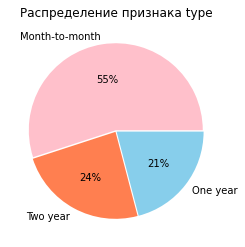

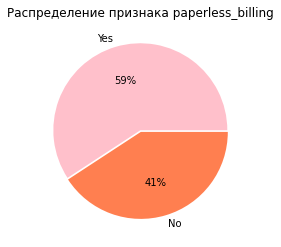

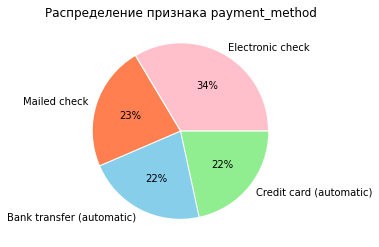

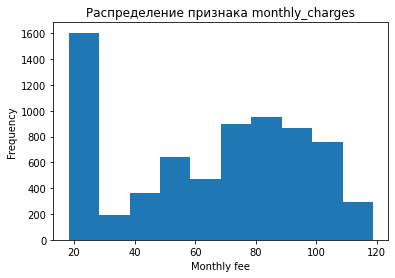

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: monthly_charges, dtype: float64


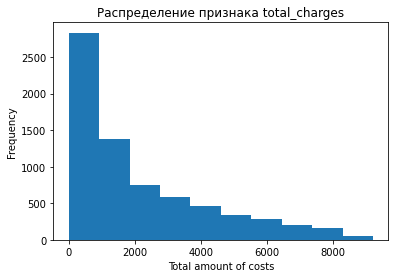

count    7043.000000
mean     2115.312885
std      2112.742814
min         0.000000
25%       436.750000
50%      1343.350000
75%      3236.690000
max      9221.380000
Name: total_charges, dtype: float64


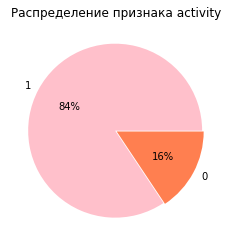

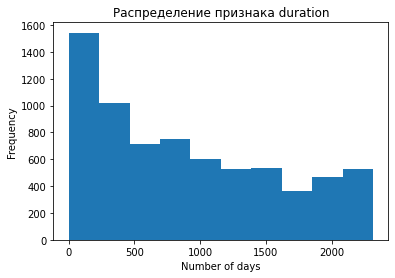

count    7043.000000
mean      898.555729
std       683.130510
min         0.000000
25%       276.000000
50%       761.000000
75%      1461.000000
max      2314.000000
Name: duration, dtype: float64


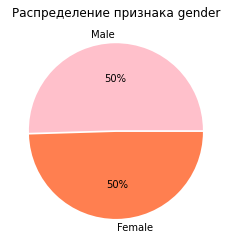

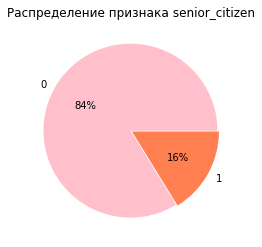

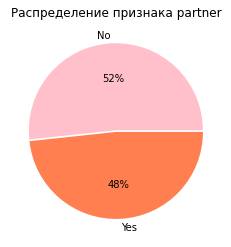

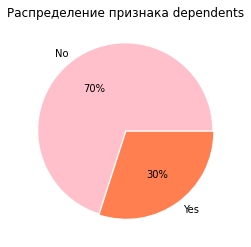

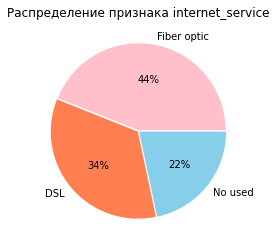

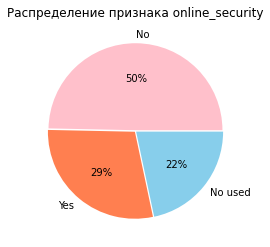

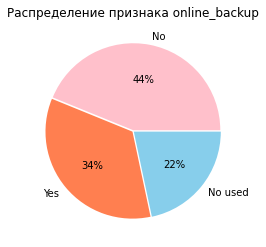

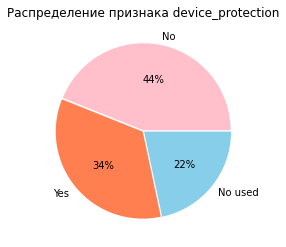

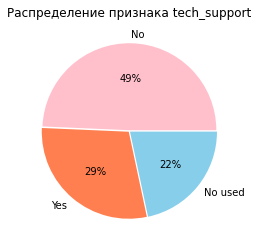

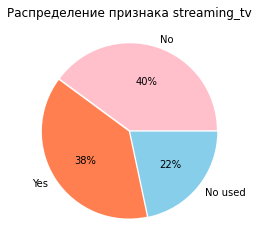

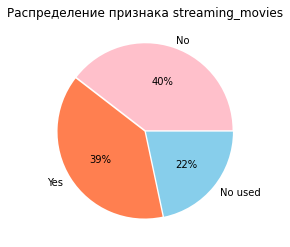

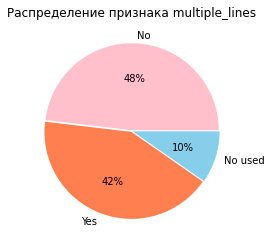

In [32]:
colors = ['pink', 'coral','skyblue', 'lightgreen'] 
explode = (0.01,)

for column in final_new.columns:
    if column in category_cols or column == 'activity':
        final_new[column].value_counts().plot(kind='pie',autopct='%1.0f%%', colors=colors[0:len(final_new[column].unique())], explode=(explode*len(final_new[column].unique())), title=f'Распределение признака {column}', label='')
        plt.show()
    if column in numeric_cols:
        final_new[column].plot(kind='hist')
        plt.title(f'Распределение признака {column}')
        if column == 'monthly_charges':
            plt.xlabel('Monthly fee')
        if column == 'total_charges':
            plt.xlabel('Total amount of costs')
        if column == 'duration':
            plt.xlabel('Number of days')
        plt.show()
        print(final_new[column].describe())    

### Вывод

Построив распределения всех признаков из объединенного датафрейма, мы можем сказать следующее:

- Чуть больше половины всех пользователей платят за услуги ежемесячно, а не раз в год или два;

- Почти 60% пользователей препочитают электронный расчетный лист;

- Самый популярный тип платежа - electronic check (34% пользователя пользуются таким);

- Присутствует явный дисбаланс класса активности пользоватей, так как видно явный "перекос" в сторону активности договора (84% пользователей на момент выгрузки данных не прерывали договор). Однако, балансировать данные мы не будем, так как метрика ROC-AUC не чувствительна к дисбалансу;

- Cоотношение мужчин и женщин, пользующихся услугами компании "ТелеДом" равное;

- Только 16% всех пользователей достигли пенсионного возраста;

- Примерно равное соотношение пользователей, которые женаты и не женаты (52% и 48% соответственно), при этом 70% абонентов не имеют детей;

- Большинство пользоватей, если пользуются услугами интернета у данной компании, предпочитают подключение через оптоволоконный кабель (44% абонентов);

- В основном, большинство людей, зарегистрированных в системе, не подключают услуги интернета в данной компании;

----
Также, что касается количественных признаков, делаем следующие выводы:

- Распределение этих признаков вовсе не похоже на нормальное, поэтому в будущем будем их нормализовывать для корректной работы модели

## Корреляционный анализ

Для того, чтобы понять, насколько сильная зависимость между целевым и входными признаками, будем использовать phik_matrix

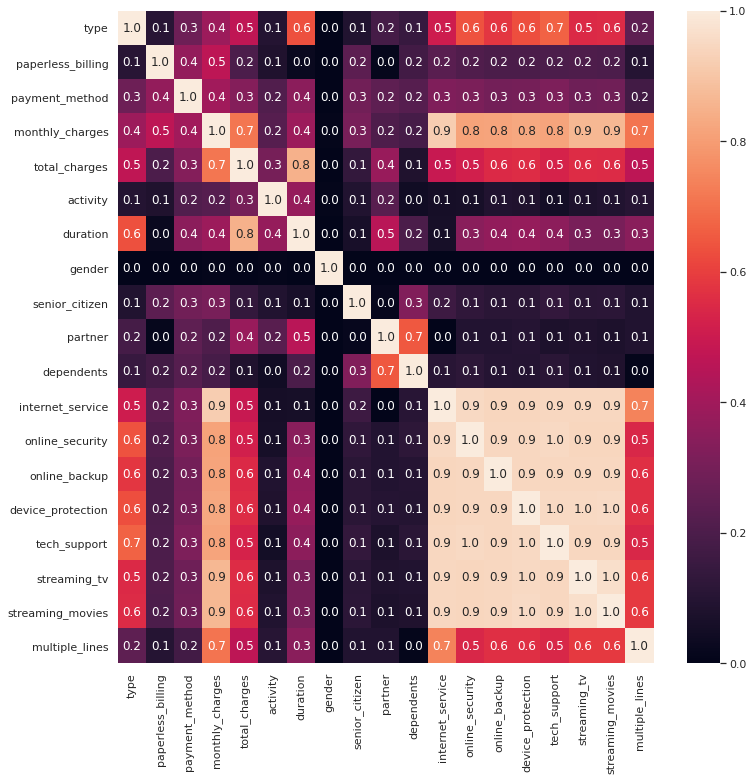

In [33]:
sns.set_theme(rc={'figure.figsize':(12,12)})
data_corr = final_new.drop('customer_id', axis=1)

sns.heatmap(data_corr.phik_matrix(interval_cols=numeric_cols), annot=True, fmt='.1f')
plt.show()

Видим, что между признаками присутствует мультиколлинеарность, которую не стоит оставлять.

Для дальнейшей работы с моделью оставим следующие признаки, которые имеют достаточную корреляцию с целевым признаком и имеют корреляцию менее 0.8 с другими признаками: ***type***, ***paperless_billing***, ***payment_method***, ***total_charges***, ***duration***, ***senior_citizen***, ***partner***, ***online_security***, ***tech_support***, ***multiple_lines***

In [34]:
final_columns = ['type', 'paperless_billing', 'payment_method', 'total_charges', 
                 'duration', 'senior_citizen', 'partner', 'online_security', 
                 'tech_support', 'multiple_lines', 'activity']
final = final_new[final_columns]
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   total_charges      7043 non-null   float64
 4   duration           7043 non-null   int64  
 5   senior_citizen     7043 non-null   int64  
 6   partner            7043 non-null   object 
 7   online_security    7043 non-null   object 
 8   tech_support       7043 non-null   object 
 9   multiple_lines     7043 non-null   object 
 10  activity           7043 non-null   int64  
dtypes: float64(1), int64(3), object(7)
memory usage: 660.3+ KB


Оставили в итоговом датафрейме только те столбцы, которые будут нужны для нашего анализа

## Подготовка данных и обучение моделей

Переходим к подготовке данных и обучению моделей

In [35]:
RANDOM_STATE = 130125
TEST_SIZE = 0.25

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    final.drop('activity', axis=1),
    final['activity'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = final['activity']
)

In [37]:
ohe_columns = ['type', 'paperless_billing', 'payment_method', 
               'senior_citizen', 'partner', 'online_security', 
               'tech_support', 'multiple_lines']

ord_columns = ohe_columns

num_columns = ['duration', 'total_charges']

### Модель LogisticRegression

In [38]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), ohe_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

In [39]:
param_distributions = [
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

In [40]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель логистической регрессии и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели при кросс-валидации:', randomized_search.best_score_)

Лучшая модель логистической регрессии и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['type', 'paperless_billing',
                                                   'payment_method',
                                                   'senior_citizen', 'partner',
                                                   'online_security',
                                                   'tech_support',
                                                   'multiple_lines']),
                                                 ('num', MinMaxScaler(),
                                                  ['duration',
                                                   't

Видим, что лучшая метрика моделей логистической регрессии при кросс-валидации 0.74. Пробуем на наших данных обучить модели DecisionTreeRegressor и LGBMClassifier, посмотрим на их метрики.

### Модели DecisionTreeRegressor и LGBMClassifier

In [41]:
data_preprocessor = ColumnTransformer(
    [
        ('ord', OrdinalEncoder(), ohe_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

In [42]:
param_distributions = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,7),
        'models__max_features': range(2,7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [lgb(random_state=RANDOM_STATE)],
        'models__learning_rate': [0.1, 0.2],
        'models__subsample_for_bin': [10000],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

In [43]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1, 
    random_state=RANDOM_STATE
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели при кросс-валидации:', randomized_search.best_score_)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 379, in _score
    response_method = _check_response_method(estimator, self._response_method)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py", line 2283, in _check_response_method
    raise AttributeError(
AttributeError: Pipeline has none of the following attributes: decision_function, predict_prob

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord', OrdinalEncoder(),
                                                  ['type', 'paperless_billing',
                                                   'payment_method',
                                                   'senior_citizen', 'partner',
                                                   'online_security',
                                                   'tech_support',
                                                   'multiple_lines']),
                                                 ('num', MinMaxScaler(),
                                                  ['duration',
                                                   'total_charges'])])),
                ('models',
                 LGBMClassifier(learning_rate=0.2, random_state=130125,
                                subsample_for_bin=10000

В данном переборе моделей и гиперпараметров мы увидели, что при кросс-валидации лучшая модель показывает метрику 0.88, что явно больше метрики, полученной у логистической регрессии, и больше 0.85.

### Проверка модели на тестовых данных

**Лучшая модель**: LGBMClassifier (learning_rate=0.2, random_state=130125, subsample_for_bin=10000))].
При кросс-валидации метрика ROC_AUC равна 0.88 > 0.85.

Именно этой модели передадим наши тестовые данные и посмотрим на метрику ROC-AUC

In [44]:
y_test_pred = randomized_search.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred[:,1])}')

Метрика ROC-AUC на тестовой выборке: 0.9102642848403278


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Метрика ROC_AUC на тестовой выборке равна 0.91, еще выше, чем при кросс-валидации

### ROC-кривая лучшей модели

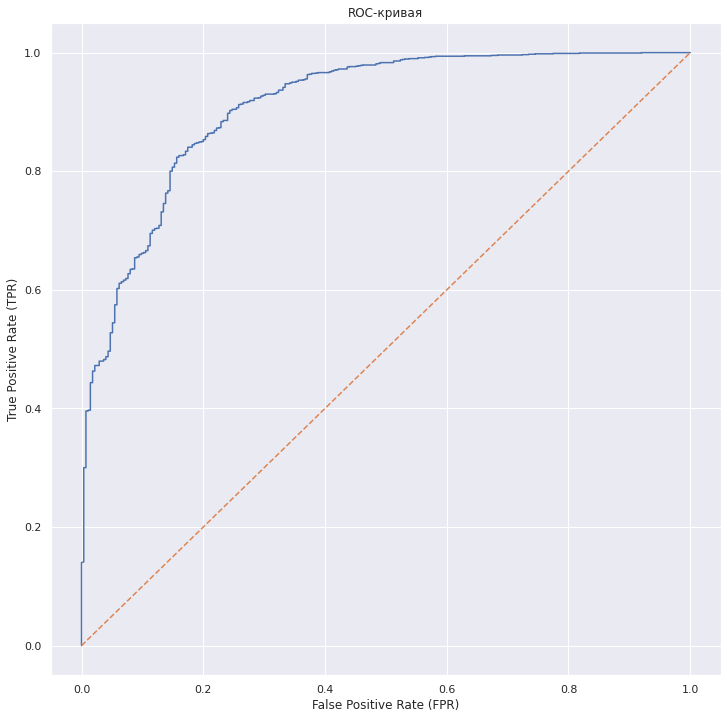

In [45]:
fpr, tpr, threshold = roc_curve(y_test, y_test_pred[:,1])
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='dashed', label='Random prediction')

plt.title("ROC-кривая")
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.show()

ROC-кривая сильно выпукла вверх (лежит явно выше, чем отрезок предсказаний случайной модели), следовательно в большинстве случаев модель делает верные предсказания (площадь под графиков ROC-кривой 0.91)

### Метрика accuracy

In [46]:
print('Метрика accuracy:', accuracy_score(y_test, randomized_search.predict(X_test)))

Метрика accuracy: 0.909710391822828


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Посчитав метрику accuracy, можем сказать, что в почти в 91% случаев наша модель верно предсказывает результат.

### Матрица ошибок

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


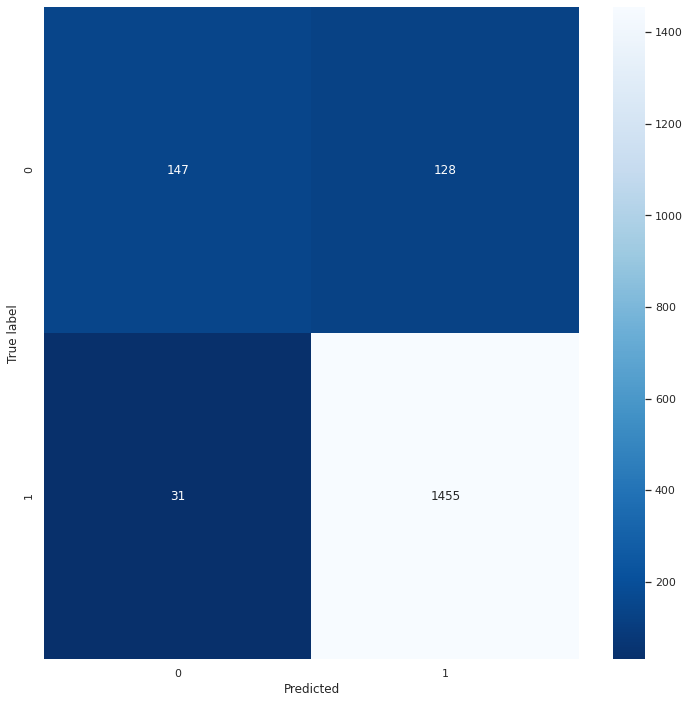

In [47]:
cm = confusion_matrix(y_test, randomized_search.predict(X_test))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted'); 

Как мы можем заметить по матрице ошибок, модель в большинстве случаев (примерно 98%) абсолютно правильно предсказывает класс 1 - активность договора. Этот класс как раз и является преобладающих в данных.

Однако, примерно в половине случаев модель ошибается в предсказании того, что пользователь рассторгнул договор.

### Анализ важности признаков

In [48]:
preprocessor = randomized_search.best_estimator_.named_steps['preprocessor']
lgbclf = randomized_search.best_estimator_.named_steps['models']

pd.DataFrame(lgbclf.booster_.feature_importance(), 
    index=randomized_search.best_estimator_[:-1].get_feature_names_out(),
    columns=['Важность признаков']).sort_values(by='Важность признаков', ascending=False)

,Важность признаков
num__duration,1399
num__total_charges,884
ord__payment_method,162
ord__type,124
ord__multiple_lines,96
ord__partner,78
ord__paperless_billing,74
ord__online_security,71
ord__tech_support,71
ord__senior_citizen,41


Проведя анализ важности признаков, можем сказать, что самый значимый показатель, который влияет на активность договора, - его длительность. Также весомую значимость имеет показатель количества всех потраченных на услуги денег.

Самый незначимый для модели признак - статус пенсионера.

### Проверка модели на адекватность

Проверим модель на адекватность с помощью DummyClassifier

In [49]:
dummy = DummyClassifier()
dummy.fit(X_train, y_train)

dummy_model_preds = dummy.predict_proba(X_test)[:, 1]

dummy_roc = roc_auc_score(y_test, dummy_model_preds)
print('Model roc_auc =', round(dummy_roc, 2))

Model roc_auc = 0.5


Как видим, в данном случае метрика модели упала до 0.5. Следовательно, наша выбранная модель вполне адекватна и все-таки работает успешно.

## Общий вывод

Таким образом, цель нашего проекта выполнена. Метрика ROC-AUC на выбранной модели показала результат 0.88 при кросс-валидации и 0.91 на тестовой выборке.

-----
Для достижения результата мы:

- Загрузили все необходимые библиотеки и данные;

- Провели предобработку всех датафреймов: привели названия столбцов к змеиному регистру, поменяли тип данных, проверили на наличие дубликатов и пропусков, добавили новые и более значимые для анализа, признаки;

- Объединили все данные в один датафрейм;

- Провели исследовательский анализ объединенного датафрейма, посмотрели на расспределение каждого признака;

- Провели корреляционный анализ, увидели мультиколлинеарность и оставили для дальнейшей работы с моделью в датафрейме следующие признаки: ***type***, ***paperless_billing***, ***payment_method***, ***total_charges***, ***duration***, ***senior_citizen***, ***partner***, ***online_security***, ***tech_support***, ***multiple_lines***;

- Подготовили данные к обучению моделей;

- Обучили три модели: **LogisticRegression**, **DecisionTreeClassifier** и **LGBMClassifier**,- перебирая гиперпараметры для каждой.

----
Лучшей моделью оказалась **LGBMClassifier** с гиперпараметрами **learning_rate = 0.2, random_state = 130125, subsample_for_bin = 10000**. 

Лучшую модель мы проверили на адекватность, посчитали метрику accuracy, разобрали матрицу ошибок и провели анализ важности признаков.


## Рекомендации заказчику

1) Хотелось бы обратить внимание на то, что далеко не все данные, которые предоставлены в датафреймах, оказались важны для использования моделей машинного обучения: 

- Например, факт активности договора и длительность намного важнее для моделей нежели даты заключения и расторжения договора;

- Также, все признаки в датафрейме ***internet_new*** сильно коррелируют друг с другом, поэтому все вместе они не могут быть полезны для моделей.

2) Некоторые типы в данных были указаны неправильно (например, ***total_charges*** или ***begin_date***). Возможно, при выгрузке данных нужно более тщательно обращать на это внимание.